# Project Demonstration

## Host image

In [1]:
from iEnc import encrypt, decrypt, rgb_to_grey, get_loss
from skimage import io
import time
import warnings
warnings.filterwarnings('ignore')

Duplicate key in file '/Users/parijatparimal/.matplotlib/matplotlibrc' line #2.


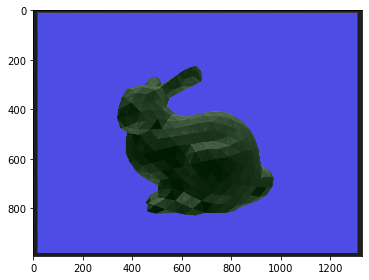

In [2]:
io.imshow('bunny.png')
io.show()

## Secret image

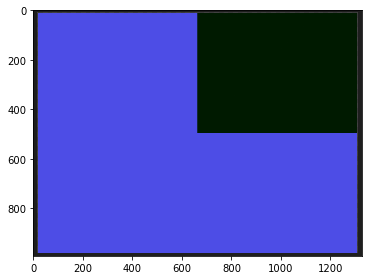

In [3]:
io.imshow('cube.png')
io.show()

## Watermarking secret image into the host image

Basic concept of watermarking an image inside another image is to insert the RGB values of each pixel in secret image into pixels of host image, such that the pixel values of host images are not disturbed much. The idea is to use the least significant bits of the pixel to store the pixel of secret image and when we want the secret image back, the values in least significant bits can be extracted and appropriately rescaled to get the secret image. It is also important to note that image formats use uint-8 format, hence each pixel has at most 8 bits. The least significant bits could then be the last two bits for example.
<br><br>
An interesting observation here is that there is an inherent tradeoff of losses involved in this watermarking process. For example, if out of the 8 bits, if only 1 bit is allotted for secret image, the information of 8 bits of secret image pixel needs to be represented in 1 bit would lead to loss if actual pixel value in secret image. On the other hand, if 4 bits out of the 8 bits of host image pixels are used to store pixel values of secret image, the watermarked image will not be able to hide the secret image, as the secret image will have significant representation in the watermarked image. Also, some amount of loss is still expected for secret image even when compressing 8 bit into 4 bits.
<br><br>
We present algorithms incrementally, such that, each successor algorithm attempts to fix the problems in predecessor algorithms.

## Algorithm 1 - Simple addition into least significant bits

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


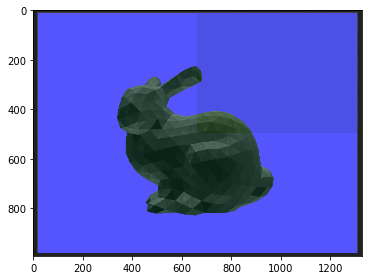

Time to watermark = 1.2396421432495117


In [4]:
import numpy as np
start = time.time()
img = io.imread('bunny.png')
bunny = np.array(img)/255
img = io.imread('cube.png')
cube = np.array(img)/255

significance_parameter = 10

watermarked_image = bunny + (cube / significance_parameter)
watermarked_image[:,:,3] = 1
io.imsave('out.png', watermarked_image)
io.imshow('out.png')
io.show()
print("Time to watermark =",time.time() - start)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


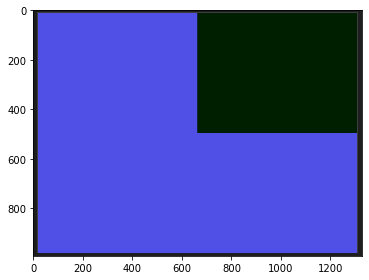

Time to extract secret image = 0.5502750873565674


In [5]:
start = time.time()
img = io.imread('out.png')
wt_image = np.array(img)/255
secret_image = (wt_image - bunny) * significance_parameter
secret_image[:,:,3] = 1
io.imsave('out1.png', secret_image)
io.imshow('out1.png')
io.show()
print("Time to extract secret image =",time.time() - start)

We can see if we allow secret image to have significant bits, the secret image becomes faintly visible in the watermarked image. If the significance parameter is increased, the host image will be the only significantly visible entity in the watermarked image, but then we will see more loss in the extracted secret image.

In [6]:
loss = get_loss('cube.png', 'out1.png')
print("RMSE loss =", loss[0])
print("PNSR accuracy =", loss[1])

RMSE loss = 6.464802124373534e-05
PNSR accuracy = 90.02525124398262


### Attack

Apart from loss, the problem here is that the algorithm is too simple, and an attacker could just subtract the host image from watermarked image to get the secret image.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


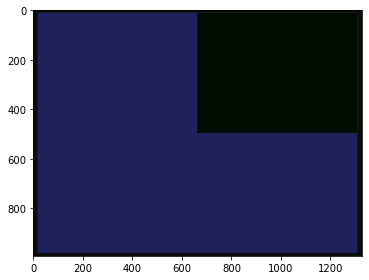

Time to extract secret image = 0.523561954498291


In [7]:
start = time.time()
img = io.imread('out.png')
wt_image = np.array(img)/255
secret_image = (wt_image - bunny) * 4
secret_image[:,:,3] = 1
io.imsave('out1.png', secret_image)
io.imshow('out1.png')
io.show()
print("Time to extract secret image =",time.time() - start)

In [8]:
loss = get_loss('cube.png', 'out1.png')
print("RMSE loss =", loss[0])
print("PNSR accuracy =", loss[1])

RMSE loss = 0.06333899194370195
PNSR accuracy = 60.11409213685056


Although, there is some difference in the original secret image and the one retrieved by the attacker (the shade of blue color), the attacker is able to retrieve almost the same image as some genuine user.

## Optional Algorithm -  DCT-DWT

DCT and DWT are different mathematical tools that help us compress 8 bits into lesser number of bits with less loss. This algorithm works better with grayscale images as shown below. We had better expectations with this algorithm, but there seems to be lots of ditortions in the images obtained with this algorithm. It was also notices, that host image is also not required to retrieve the secret image. If the attacker knows that this algorithm was used, that would be enough to recover the image. Honestly, this algorithm did not improve anything, hence we mostly skipped this algorithm during presentation.

### Grayscale host image

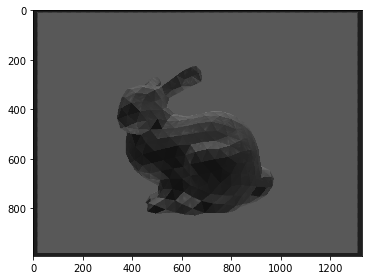

In [9]:
io.imshow(rgb_to_grey(io.imread('bunny.png')))
io.show()

### Grayscale secret image

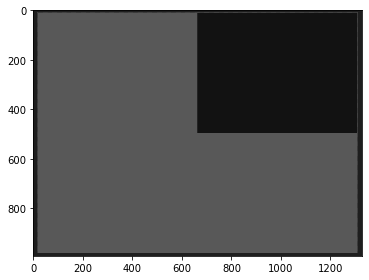

In [10]:
io.imshow(rgb_to_grey(io.imread('cube.png')))
io.show()

### Watermarked image

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


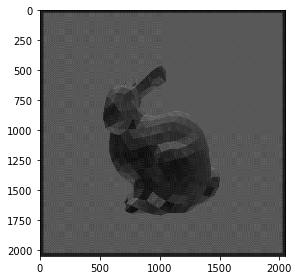

Time to watermark = 2.678652286529541


In [11]:
start = time.time()
encrypt('bunny.png','cube.png','dctdwt','out2.png')
io.imshow('out2.png')
io.show()
print("Time to watermark =",time.time() - start)

### Extracted secret image

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


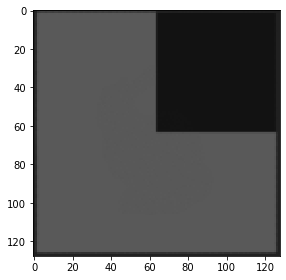

Time to extract secret image = 0.7700419425964355


In [12]:
start = time.time()
decrypt('bunny.png','out2.png','dctdwt','out3.png')
io.imshow('out3.png')
io.show()
print("Time to extract secret image =",time.time() - start)

It can be seen that there are many problems with this algorithm:
<br>
1. Watermarked image looks distorted
2. Output images are reshaped
3. If the algorithm known to attacker, easy to extract the secret image

<br>
Because of these issues, this algorithm was found to be ineffective and hence we did not consider it further for our use cases.

## Algorithm 2 - Discrete Cosine Transformation (DCT)

### Watermarked image

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


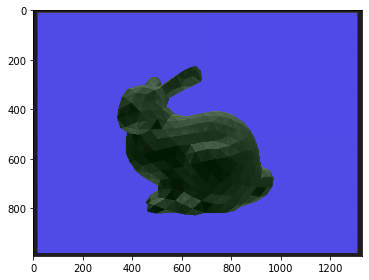

Time to watermark = 1.7930259704589844


In [13]:
start = time.time()
encrypt('bunny.png','cube.png','dct','out.png',ll=0)
io.imshow('out.png')
io.show()
print("Time to watermark =",time.time() - start)

### Extracted secret image

Lossy conversion from float64 to uint8. Range [-0.16827871288402907, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


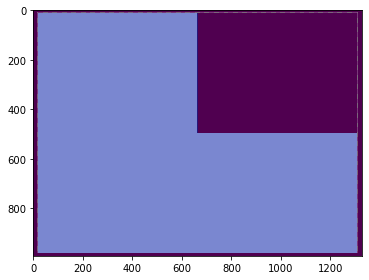

Time to extract secret image = 0.7844700813293457


In [14]:
start = time.time()
decrypt('bunny.png','out.png','dct','out1.png',ll=0)
io.imshow('out1.png')
io.show()
print("Time to extract secret image =",time.time() - start)

In [15]:
loss = get_loss('cube.png', 'out1.png')
print("RMSE loss =", loss[0])
print("PNSR accuracy =", loss[1])

RMSE loss = 0.029498219398527564
PNSR accuracy = 63.43284559423069


### Attack

Lossy conversion from float64 to uint8. Range [-0.007843137254901988, 0.011764705882352955]. Convert image to uint8 prior to saving to suppress this warning.


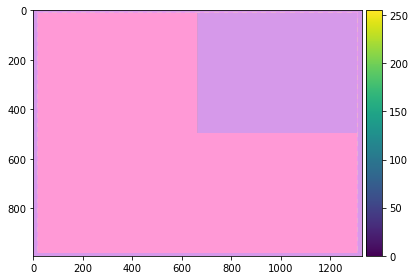

Time to attack = 0.6092240810394287


In [16]:
start = time.time()
img = io.imread('out.png')
watermarked_image = np.array(img)/255
secret_image = (watermarked_image - bunny)
io.imsave('out2.png', secret_image)
img = io.imread('out2.png')
io.imshow(img)
io.show()
print("Time to attack =",time.time() - start)

In [17]:
loss = get_loss('cube.png', 'out2.png')
print("RMSE loss =", loss[0])
print("PNSR accuracy =", loss[1])

RMSE loss = 0.27767493033090657
PNSR accuracy = 53.69543689293475


## Algorithm 3 - Discrete Cosine Transformation (DCT) with shuffle

### Watermarked image

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


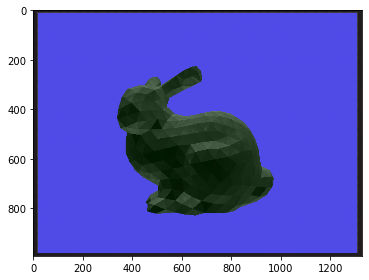

Time to watermark = 124.6325569152832


In [18]:
start = time.time()
encrypt('bunny.png','cube.png','dct','out.png',shuffle=1, r1=13241324, r2=24132413, ll=0)
io.imshow('out.png')
io.show()
print("Time to watermark =",time.time() - start)

### Extracted secret image

Lossy conversion from float64 to uint8. Range [-0.16827871288402907, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


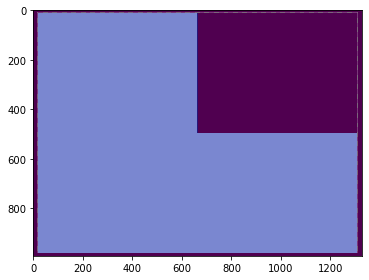

Time to extract secret image = 117.68118786811829


In [19]:
start = time.time()
decrypt('bunny.png','out.png','dct','out1.png',shuffle=1, r1=13241324, r2=24132413, ll=0)
io.imshow('out1.png')
io.show()
print("Time to extract secret image =",time.time() - start)

In [20]:
loss = get_loss('cube.png', 'out1.png')
print("RMSE loss =", loss[0])
print("PNSR accuracy =", loss[1])

RMSE loss = 0.029498219398527564
PNSR accuracy = 63.43284559423069


### Attack 1 - Subtracting host image from watermarked image

Lossy conversion from float64 to uint8. Range [-0.007843137254901988, 0.011764705882352955]. Convert image to uint8 prior to saving to suppress this warning.


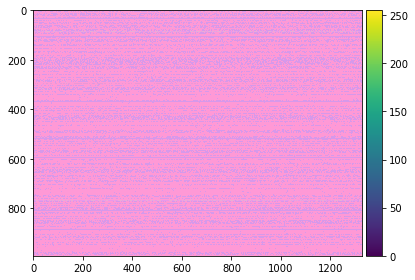

Time to attack = 3.8685641288757324


In [21]:
start = time.time()
img = io.imread('out.png')
watermarked_image = np.array(img)/255
secret_image = (watermarked_image - bunny)
io.imsave('out2.png', secret_image)
img = io.imread('out2.png')
io.imshow(img)
io.show()
print("Time to attack =",time.time() - start)

In [22]:
loss = get_loss('cube.png', 'out2.png')
print("RMSE loss =", loss[0])
print("PNSR accuracy =", loss[1])

RMSE loss = 0.27119127333575266
PNSR accuracy = 53.798046506105905


### Attack 2 - Using DCT algorithm to extract secret image from watermarked image

Lossy conversion from float64 to uint8. Range [-0.16827871288402907, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


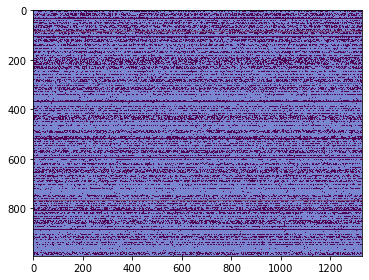

Time to extract secret image = 3.871784210205078


In [23]:
start = time.time()
decrypt('bunny.png','out.png','dct','out2.png', ll=0)
io.imshow('out2.png')
io.show()
print("Time to extract secret image =",time.time() - start)

In [24]:
loss = get_loss('cube.png', 'out2.png')
print("RMSE loss =", loss[0])
print("PNSR accuracy =", loss[1])

RMSE loss = 0.08966051202813713
PNSR accuracy = 58.60479146186904


### Attack 3 - Using DCT algorithm with shuffle to extract secret image from watermarked image

Lossy conversion from float64 to uint8. Range [-0.16827871288402907, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


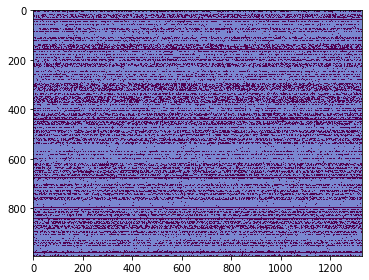

Time to extract secret image = 120.93676424026489


In [25]:
start = time.time()
decrypt('bunny.png','out.png','dct','out2.png',shuffle=1, r1=53241324, r2=54132413, ll=0)
io.imshow('out2.png')
io.show()
print("Time to extract secret image =",time.time() - start)

In [26]:
loss = get_loss('cube.png', 'out2.png')
print("RMSE loss =", loss[0])
print("PNSR accuracy =", loss[1])

RMSE loss = 0.09013685574129965
PNSR accuracy = 58.58177956434261


### Attack 4 - Using DCT algorithm with shuffle with one correct seed value

Lossy conversion from float64 to uint8. Range [-0.16827871288402907, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


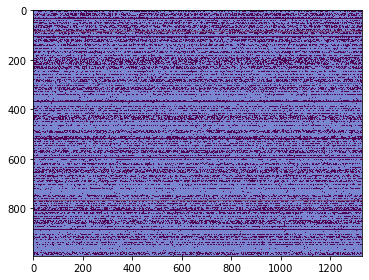

Time to extract secret image = 3.8737759590148926


In [27]:
start = time.time()
decrypt('bunny.png','out.png','dct','out2.png',shuffle=0, r1=53241324, r2=24132413, ll=0)
io.imshow('out2.png')
io.show()
print("Time to extract secret image =",time.time() - start)

In [28]:
loss = get_loss('cube.png', 'out2.png')
print("RMSE loss =", loss[0])
print("PNSR accuracy =", loss[1])

RMSE loss = 0.08966051202813713
PNSR accuracy = 58.60479146186904


Lossy conversion from float64 to uint8. Range [-0.16827871288402907, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


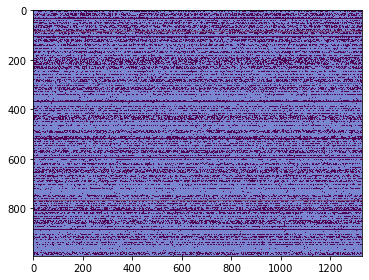

Time to extract secret image = 4.243980169296265


In [29]:
start = time.time()
decrypt('bunny.png','out.png','dct','out2.png',shuffle=0, r1=13241324, r2=54132413, ll=0)
io.imshow('out2.png')
io.show()
print("Time to extract secret image =",time.time() - start)

In [30]:
loss = get_loss('cube.png', 'out2.png')
print("RMSE loss =", loss[0])
print("PNSR accuracy =", loss[1])

RMSE loss = 0.08966051202813713
PNSR accuracy = 58.60479146186904


# Lossless model for algorithms 1, 2 and 3

## Algorithm 1 - Simple addition into least significant bits

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


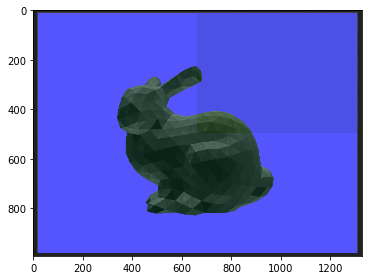

Time to watermark = 1.3221790790557861


In [31]:
import numpy as np
start = time.time()
img = io.imread('bunny.png')
bunny = np.array(img)/255
img = io.imread('cube.png')
cube = np.array(img)/255

significance_parameter = 10

watermarked_image = bunny + (cube / significance_parameter)
watermarked_image[:,:,3] = 1
io.imsave('out.png', watermarked_image)
io.imshow('out.png')
io.show()
print("Time to watermark =",time.time() - start)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


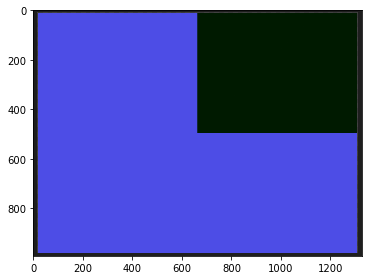

Time to extract secret image = 0.6219620704650879


In [32]:
start = time.time()
img = io.imread('out.png')
wt_image = watermarked_image
secret_image = (wt_image - bunny) * significance_parameter
secret_image[:,:,3] = 1
io.imsave('out1.png', secret_image)
io.imshow('out1.png')
io.show()
print("Time to extract secret image =",time.time() - start)

We can see if we allow secret image to have significant bits, the secret image becomes faintly visible in the watermarked image. If the significance parameter is increased, the host image will be the only significantly visible entity in the watermarked image, but then we will see more loss in the extracted secret image.

In [33]:
loss = get_loss('cube.png', 'out1.png')
print("RMSE loss =", loss[0])
print("PNSR accuracy =", loss[1])

RMSE loss = 0.0
PNSR accuracy = 100


### Attack

Apart from loss, the problem here is that the algorithm is too simple, and an attacker could just subtract the host image from watermarked image to get the secret image.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


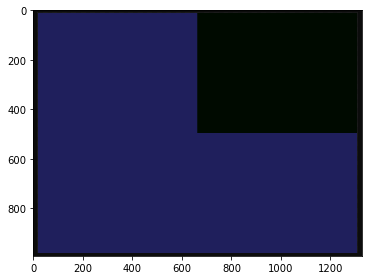

Time to extract secret image = 0.5897018909454346


In [34]:
start = time.time()
img = io.imread('out.png')
wt_image = watermarked_image
secret_image = (wt_image - bunny) * 4
secret_image[:,:,3] = 1
io.imsave('out1.png', secret_image)
io.imshow('out1.png')
io.show()
print("Time to extract secret image =",time.time() - start)

In [35]:
loss = get_loss('cube.png', 'out1.png')
print("RMSE loss =", loss[0])
print("PNSR accuracy =", loss[1])

RMSE loss = 0.0638838110410817
PNSR accuracy = 60.076895444355515


Although, there is some difference in the original secret image and the one retrieved by the attacker (the shade of blue color), the attacker is able to retrieve almost the same image as some genuine user.

## Algorithm 2 - Discrete Cosine Transformation (DCT)

### Watermarked image

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


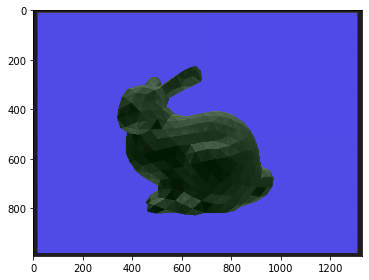

Time to watermark = 111.41525769233704


In [36]:
start = time.time()
encrypt('bunny.png','cube.png','dct','out.png',ll=1)
io.imshow('out.png')
io.show()
print("Time to watermark =",time.time() - start)

### Extracted secret image

Lossy conversion from float64 to uint8. Range [-0.11833090738319063, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


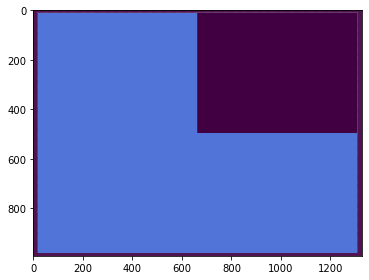

Time to extract secret image = 3.0655391216278076


In [37]:
start = time.time()
decrypt('bunny.png','out.png','dct','out1.png',ll=1)
io.imshow('out1.png')
io.show()
print("Time to extract secret image =",time.time() - start)

In [38]:
loss = get_loss('cube.png', 'out1.png')
print("RMSE loss =", loss[0])
print("PNSR accuracy =", loss[1])

RMSE loss = 0.013962391141705322
PNSR accuracy = 66.68120560723904


### Attack

Lossy conversion from float64 to uint8. Range [-0.007843137254901988, 0.011764705882352955]. Convert image to uint8 prior to saving to suppress this warning.


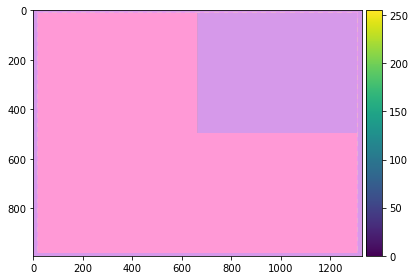

Time to attack = 0.6588060855865479


In [39]:
start = time.time()
img = io.imread('out.png')
watermarked_image = np.array(img)/255
secret_image = (watermarked_image - bunny)
io.imsave('out2.png', secret_image)
img = io.imread('out2.png')
io.imshow(img)
io.show()
print("Time to attack =",time.time() - start)

In [40]:
loss = get_loss('cube.png', 'out2.png')
print("RMSE loss =", loss[0])
print("PNSR accuracy =", loss[1])

RMSE loss = 0.27767493033090657
PNSR accuracy = 53.69543689293475


## Algorithm 3 - Discrete Cosine Transformation (DCT) with shuffle

### Watermarked image

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


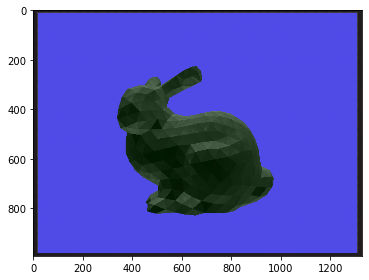

Time to watermark = 239.24025082588196


In [41]:
start = time.time()
encrypt('bunny.png','cube.png','dct','out.png',shuffle=1, r1=13241324, r2=24132413, ll=1)
io.imshow('out.png')
io.show()
print("Time to watermark =",time.time() - start)

### Extracted secret image

Lossy conversion from float64 to uint8. Range [-0.11833094141603384, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


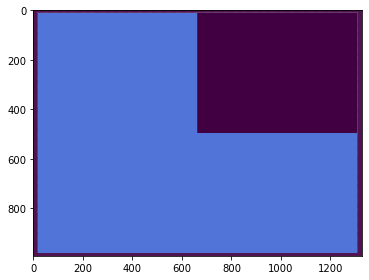

Time to extract secret image = 127.22199130058289


In [42]:
start = time.time()
decrypt('bunny.png','out.png','dct','out1.png',shuffle=1, r1=13241324, r2=24132413, ll=1)
io.imshow('out1.png')
io.show()
print("Time to extract secret image =",time.time() - start)

In [43]:
loss = get_loss('cube.png', 'out1.png')
print("RMSE loss =", loss[0])
print("PNSR accuracy =", loss[1])

RMSE loss = 0.013962391141705322
PNSR accuracy = 66.68120560723904


### Attack 1 - Subtracting host image from watermarked image

Lossy conversion from float64 to uint8. Range [-0.007843137254901988, 0.011764705882352955]. Convert image to uint8 prior to saving to suppress this warning.


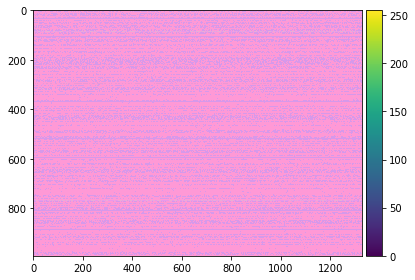

Time to attack = 4.334909915924072


In [44]:
start = time.time()
img = io.imread('out.png')
watermarked_image = np.array(img)/255
secret_image = (watermarked_image - bunny)
io.imsave('out2.png', secret_image)
img = io.imread('out2.png')
io.imshow(img)
io.show()
print("Time to attack =",time.time() - start)

In [45]:
loss = get_loss('cube.png', 'out2.png')
print("RMSE loss =", loss[0])
print("PNSR accuracy =", loss[1])

RMSE loss = 0.27119127333575266
PNSR accuracy = 53.798046506105905


### Attack 2 - Using DCT algorithm to extract secret image from watermarked image

Lossy conversion from float64 to uint8. Range [-0.11833094141603384, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


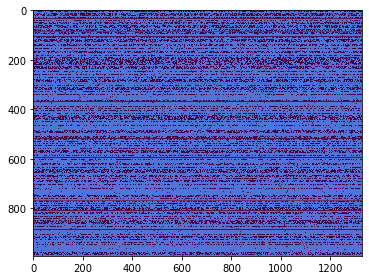

Time to extract secret image = 6.0262651443481445


In [46]:
start = time.time()
decrypt('bunny.png','out.png','dct','out2.png', ll=1)
io.imshow('out2.png')
io.show()
print("Time to extract secret image =",time.time() - start)

In [47]:
loss = get_loss('cube.png', 'out2.png')
print("RMSE loss =", loss[0])
print("PNSR accuracy =", loss[1])

RMSE loss = 0.07709882639559425
PNSR accuracy = 59.26032593631436


### Attack 3 - Using DCT algorithm with shuffle to extract secret image from watermarked image

Lossy conversion from float64 to uint8. Range [-0.11833094141603384, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


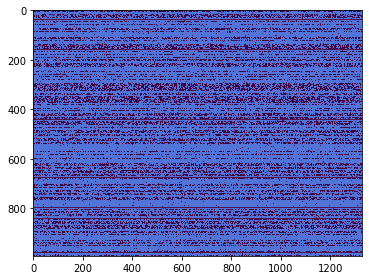

Time to extract secret image = 129.70813179016113


In [48]:
start = time.time()
decrypt('bunny.png','out.png','dct','out2.png',shuffle=1, r1=53241324, r2=54132413, ll=1)
io.imshow('out2.png')
io.show()
print("Time to extract secret image =",time.time() - start)

In [49]:
loss = get_loss('cube.png', 'out2.png')
print("RMSE loss =", loss[0])
print("PNSR accuracy =", loss[1])

RMSE loss = 0.07751851778579702
PNSR accuracy = 59.23674900793255


### Attack 4 - Using DCT algorithm with shuffle with one correct seed value

Lossy conversion from float64 to uint8. Range [-0.11833094141603384, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


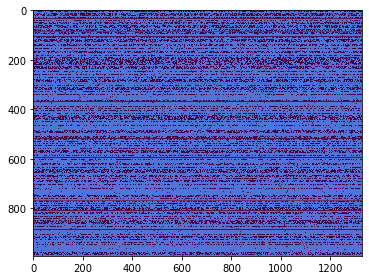

Time to extract secret image = 5.843166828155518


In [50]:
start = time.time()
decrypt('bunny.png','out.png','dct','out2.png',shuffle=0, r1=53241324, r2=24132413, ll=1)
io.imshow('out2.png')
io.show()
print("Time to extract secret image =",time.time() - start)

In [51]:
loss = get_loss('cube.png', 'out2.png')
print("RMSE loss =", loss[0])
print("PNSR accuracy =", loss[1])

RMSE loss = 0.07709882639559425
PNSR accuracy = 59.26032593631436


Lossy conversion from float64 to uint8. Range [-0.11833094141603384, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


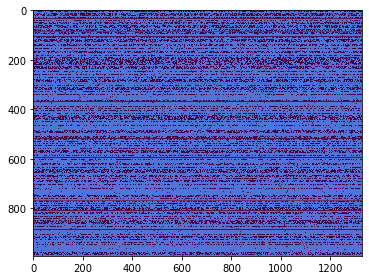

Time to extract secret image = 5.7021708488464355


In [52]:
start = time.time()
decrypt('bunny.png','out.png','dct','out2.png',shuffle=0, r1=13241324, r2=54132413, ll=1)
io.imshow('out2.png')
io.show()
print("Time to extract secret image =",time.time() - start)

In [53]:
loss = get_loss('cube.png', 'out2.png')
print("RMSE loss =", loss[0])
print("PNSR accuracy =", loss[1])

RMSE loss = 0.07709882639559425
PNSR accuracy = 59.26032593631436
